# Visual Inspection of Casting Products using Convolutional Neural Network (CNN)

## Background

Casting is the process by which metal objects are created through melting and pouring into molds. As is the case in any manufacturing process, defects or unwanted irregularities can occur and are a common problem in casting products. In order to prevent rejection and revenue loss, companies carry out a quality inspection in which they ensure their products meet the requirements specified by the consumer.

Visual inspection is a common non-destructive technique for detecting irregularities on casting products. It involves a human operator manually inspecting each test piece and classifying them as defective or non-defective. Due to the human-dependent nature of the technique, it is prone to misclassification and can be time-consuming. The problem of misclassification must be prevented because a defective product that is misclassified as OK can cause rejection of the whole production order.

In this notebook, a simple [Convolutional Neural Network (CNN)](https://www.tensorflow.org/tutorials/images/cnn) is trained to analyze images of a casting product and distinguish defective castings from the normal ones. The use of this deep learning algorithm can be proposed as a solution to help operators perform a more accurate inspection.

In [1]:
import os  # Operating system functionality
import random  # Random number generator
import pandas as pd  # Data analysis & manipulation
import numpy as np  # Array-processing
import seaborn as sns  # Data visualization
import matplotlib.pyplot as plt  # Data visualization
from tensorflow.keras import preprocessing, layers, models, callbacks  # Neural networks
from sklearn import metrics  # Model evaluation
print(f'Libraries imported.')

# # List all files under the input directory
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

Libraries imported.


## Data

The dataset consists of 7348 top-view images of cast submersible pump impellers (front side), provided by Pilot Technocast (available on [Kaggle Data](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product)). The images had previously been augmented. In the input directory, the folder *casting_data* is split into subfolders *training* and *testing*, each of which divided into subfolders denoting the class labels: *def_front* (defective) and *ok_front* (non-defective).

In [2]:
# Specify paths for training and testing data
casting_dir = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/'
train_path = casting_dir + 'train/'
train_def_path = train_path + 'def_front/'
train_ok_path = train_path + 'ok_front/'
test_path = casting_dir + 'test/'
test_def_path = test_path + 'def_front/'
test_ok_path = test_path + 'ok_front/'

# Check the size of each class in both training and testing data
print('Train data, class def_front:', len(os.listdir(train_def_path)))
print('Train data, class ok_front :', len(os.listdir(train_ok_path)))
print('Test data, class def_front :', len(os.listdir(test_def_path)))
print('Test data, class ok_front  :', len(os.listdir(test_ok_path)))

Train data, class def_front: 3758
Train data, class ok_front : 2875
Test data, class def_front : 453
Test data, class ok_front  : 262


Taking a look at random images of defective and normal casting product:

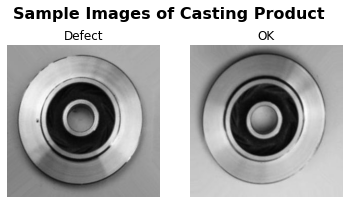

In [3]:
rand_img_def = plt.imread(
    train_def_path + random.choice(os.listdir(train_def_path)))
rand_img_ok = plt.imread(
    train_ok_path + random.choice(os.listdir(train_ok_path)))

fig, axes = plt.subplots(1, 2)
axes[0].imshow(rand_img_def, cmap='gray')
axes[1].imshow(rand_img_ok, cmap='gray')
axes[0].set_title('Defect')
axes[1].set_title('OK')
axes[0].axis('off')
axes[1].axis('off')
plt.suptitle(
    'Sample Images of Casting Product',
    y=0.9, size=16, weight='bold')
plt.show()

## Image generation and preprocessing

Pixel values of images in the train and test sets are rescaled to a range of 0-1 using [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Twenty percent of the train set is reserved for validation. Providing `train_path` and `test_path` as inputs, [flow_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) will generate batches of 32 images (300×300 pixels each). The class of defective product `def_front` is labeled as 1, the non-defective `ok_front` as 0. A seed number of 0 is given to ensure reproducibility.

In [4]:
img_size, batch_size, seed_num = (300,300), 32, 0

def generate_train_img(train_path, img_size, batch_size, seed_num):
    img_generator = preprocessing.image.ImageDataGenerator(
        rescale=1./255, validation_split=0.2)
    gen_args = dict(
        target_size=img_size,
        color_mode='grayscale',
        classes={'ok_front':0, 'def_front':1},
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True,
        seed=seed_num)
    train_data = img_generator.flow_from_directory(
        directory=train_path, subset='training', **gen_args)
    validation_data = img_generator.flow_from_directory(
        directory=train_path, subset='validation', **gen_args)
    return train_data, validation_data

def generate_test_img(test_path, img_size, batch_size, seed_num):
    img_generator = preprocessing.image.ImageDataGenerator(
        rescale=1./255)
    gen_args = dict(
        target_size=img_size,
        color_mode='grayscale',
        classes={'ok_front':0, 'def_front':1},
        class_mode='binary',
        batch_size=batch_size,
        shuffle=False,
        seed=seed_num)
    test_data = img_generator.flow_from_directory(
        directory=test_path, **gen_args)
    return test_data

# Generate the data
train_data, validation_data = generate_train_img(
    train_path, img_size, batch_size, seed_num)
test_data = generate_test_img(
    test_path, img_size, batch_size, seed_num)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


The following cell generates a visualization of the first batch (size = 32) of images that are used for training the CNN model. An image annotated with pixel values, i.e., the values that are fed into the neural networks, is displayed on the cell after that. Visualization codes are adapted from [this Kaggle Notebook](https://www.kaggle.com/tomythoven/casting-inspection-with-data-augmentation-cnn).

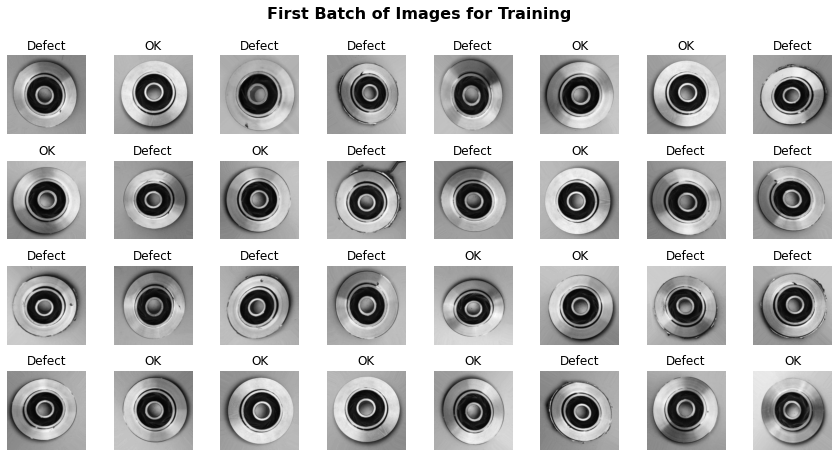

In [5]:
mapping_class = {0: 'OK', 1: 'Defect'}

def visualize_first_batch(dataset, fig_title):
    images, labels = next(iter(dataset))
    images = images.reshape(batch_size,*img_size)
    fig, axes = plt.subplots(4, 8, figsize=(12,6))
    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(mapping_class[label], size=12)
    plt.tight_layout()
    fig.suptitle(fig_title, y=1.05, size=16, weight='bold')
    plt.show()
    return images

train_batch_1 = visualize_first_batch(
    train_data,
    "First Batch of Images for Training")

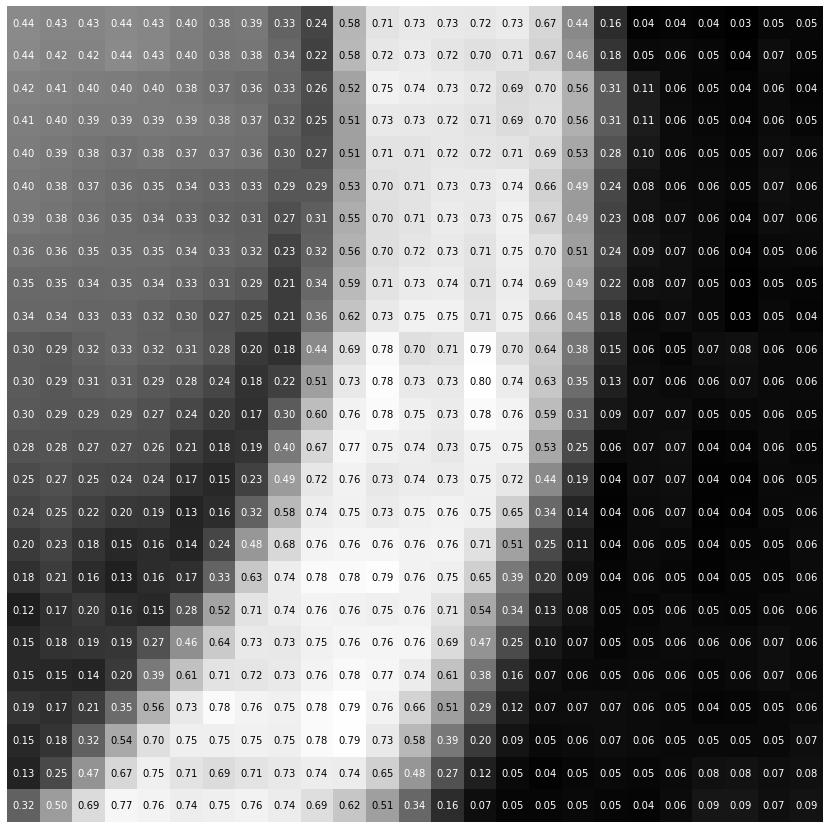

In [6]:
# Make a 25×25 pixels selection from the first image
selected_pxl = np.squeeze(train_batch_1[0])[150:175, 160:185]

def visualize_pixels(selected_pxl):
    fig, ax = plt.subplots(figsize = (15,15))
    ax.imshow(selected_pxl, cmap='gray')
    ax.axis('off')
    pxl_width, pxl_height = selected_pxl.shape
    for x in range(pxl_width):
        for y in range(pxl_height):
            value = selected_pxl[x][y]
            ax.annotate(
                '{:.2f}'.format(value),
                xy=(y,x),
                ha='center',
                va='center',
                color='white' if value<0.5 else 'black')
    
visualize_pixels(selected_pxl)

## Creating and compiling the model

The neural network consists of a convolutional base with three alternating layers of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D). The last output tensors from the convolutional base are flattened into a 1D shape and then fed through two fully-connected [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers. The `Conv2D` and the first `Dense` layers are activated with [relu (rectified linear unit)](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) activation function. A [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer is added to reduce overfitting. The activation of the last `Dense` layer is a [sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) function, which converts scores into a probability of an image being classified as defective. All of these layers are passed into the [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) constructor as a list.

After defining its architecture, the model is then compiled. The [adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer is used. Since we are dealing with a binary classification problem (only two classes), the loss function is [binary_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy). The metrics with which to monitor the training is [accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy).

In [7]:
cnn_model = models.Sequential([
    layers.Conv2D(
        filters=16,
        kernel_size=7,
        strides=2,
        activation='relu',
        padding='same',
        input_shape=img_size+(1,)),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(
        filters=32,
        kernel_size=3,
        activation='relu',
        padding='same'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(
        filters=64,
        kernel_size=3,
        activation='relu',
        padding='same'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(units=1, activation='sigmoid')])

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      800       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

## Training the model

The number of epochs, through which the entire training data is passed, is set at 25. Each epoch would require 166 steps to finish all 32 batches of image. Two [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are specified: (1) [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to stop the training when `val_loss` (validation loss) no longer improves after 5 consecutive epochs and (2) [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) to save the model that yields the best value of `val_loss`, i.e., when said value is the most minimized.

In [8]:
stop_early = callbacks.EarlyStopping(
    monitor='val_loss', patience=5)

checkpoint = callbacks.ModelCheckpoint(
    'cnn_casting_inspection.hdf5',
    verbose=1,
    save_best_only=True,
    monitor='val_loss')

n_epochs = 25

cnn_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=n_epochs,
    callbacks=[stop_early, checkpoint],
    verbose=1)

Epoch 1/25
166/166 [==============================] - 40s 224ms/step - loss: 0.6184 - accuracy: 0.6382 - val_loss: 0.2680 - val_accuracy: 0.8876

Epoch 00001: val_loss improved from inf to 0.26796, saving model to cnn_casting_inspection.hdf5
Epoch 2/25
166/166 [==============================] - 17s 101ms/step - loss: 0.2525 - accuracy: 0.8910 - val_loss: 0.1421 - val_accuracy: 0.9517

Epoch 00002: val_loss improved from 0.26796 to 0.14210, saving model to cnn_casting_inspection.hdf5
Epoch 3/25
166/166 [==============================] - 16s 98ms/step - loss: 0.1380 - accuracy: 0.9460 - val_loss: 0.0821 - val_accuracy: 0.9789

Epoch 00003: val_loss improved from 0.14210 to 0.08214, saving model to cnn_casting_inspection.hdf5
Epoch 4/25
166/166 [==============================] - 17s 102ms/step - loss: 0.0825 - accuracy: 0.9723 - val_loss: 0.0743 - val_accuracy: 0.9736

Epoch 00004: val_loss improved from 0.08214 to 0.07432, saving model to cnn_casting_inspection.hdf5
Epoch 5/25
166/166 [=

Epoch 12 yields the best result, achieving 99.60% accuracy on the training set and 99.32% on the validation set. Training was terminated after epoch 17 because validation loss no longer improved from 2.44% since epoch 12. The following plot visualizes the changes of loss and accuracy on the training and validation sets.

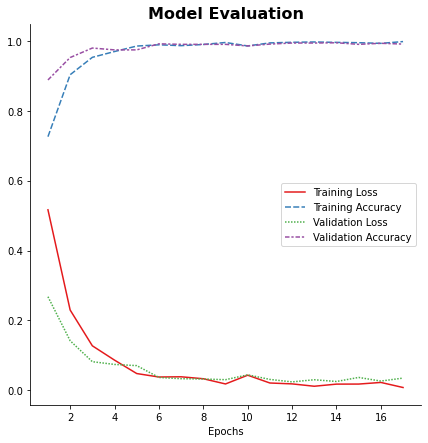

In [9]:
train_result_df = pd.DataFrame(
    cnn_model.history.history,
    index=range(1, 1+len(cnn_model.history.epoch)))

plt.subplots(figsize=(7,7))
sns.lineplot(data=train_result_df, palette='Set1')
plt.xlabel('Epochs')
plt.legend(labels=[
    'Training Loss',
    'Training Accuracy',
    'Validation Loss',
    'Validation Accuracy'])
plt.title('Model Evaluation', size=16, weight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In the plot above, both training and validation accuracies increases over time and are closely aligned, showing no sign of overfitting. The losses in the training and validation sets also progressively dropped towards 0.

## Making prediction on new data

The performance of the best model will be tested to classify images that weren't previously included in the training and validation process. The prediction outputs probability values in the range 0-1. A threshold value of 0.5 is specified to separate the classes. A prediction probabilty that is equal to or greater than the threshold will be classified as `Defect`.

23/23 [==============================] - 4s 169ms/step


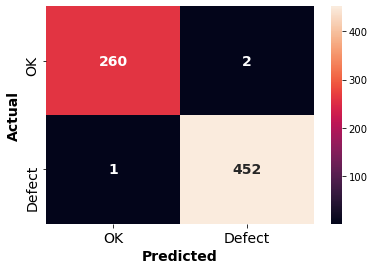

In [10]:
# Load the model with the best training results
best_model = models.load_model("/kaggle/working/cnn_casting_inspection.hdf5")

# Make predictions on images in the test set
y_pred_proba = best_model.predict(test_data, verbose=1)
threshold = 0.5
y_pred = y_pred_proba >= threshold

# Visualize the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(
    metrics.confusion_matrix(test_data.classes,y_pred),
    annot=True,
    annot_kws={'size':14, 'weight':'bold'},
    fmt='d',
    xticklabels=['OK', 'Defect'],
    yticklabels=['OK', 'Defect'])
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [11]:
print(metrics.classification_report(
    test_data.classes, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9962    0.9924    0.9943       262
           1     0.9956    0.9978    0.9967       453

    accuracy                         0.9958       715
   macro avg     0.9959    0.9951    0.9955       715
weighted avg     0.9958    0.9958    0.9958       715



The CNN model achieves a 99.58% accuracy on predicting the labels on the test set: out of 715 images, only 3 are misclassified. Befitting the problem statement (i.e., to minimize defective products being incorrectly classified as non-defectives), the number of false negatives is smaller than that of false positives, with 99.56% [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) and 99.78% [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html). Two images with actual labels `OK` are predicted as `Defect` while only 1 `Defect` predicted as `OK`.

Below is a visualization of prediction results on some random images from the test set. For each image, a comparison of the actual and predicted class label is provided as well as the probability of that image belonging on the predicted class. Visualization codes are adapted from [this Kaggle Notebook](https://www.kaggle.com/tomythoven/casting-inspection-with-data-augmentation-cnn).

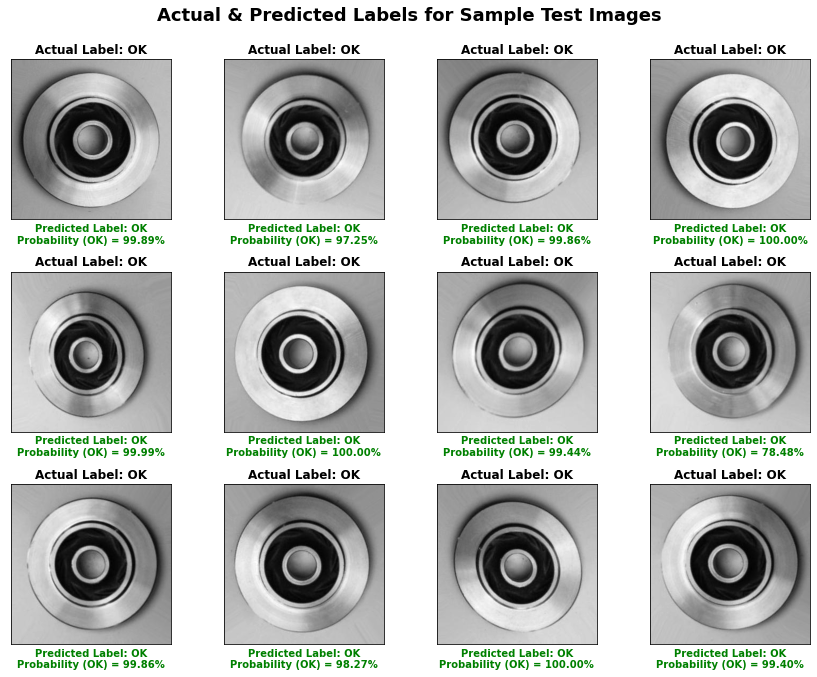

In [12]:
images, labels = next(iter(test_data))
images = images.reshape(batch_size, *img_size)
fig, axes = plt.subplots(3, 4, figsize=(12,9))

for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap='gray')
    true_label = mapping_class[label]
    [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
    pred_label = mapping_class[int(pred_prob >= threshold)]
    prob_class = 100*pred_prob if pred_label == 'Defect' else 100*(1-pred_prob)
    ax.set_title(f'Actual Label: {true_label}', weight='bold')
    ax.set_xlabel(
        f'Predicted Label: {pred_label}\nProbability ({pred_label}) = {(prob_class):.2f}%',
        weight='bold', color='green' if true_label == pred_label else 'red')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle('Actual & Predicted Labels for Sample Test Images',
             y=1.04, size=18, weight='bold')
plt.show()

## Conclusion

A convolutional neural network was created to classify images of a casting product as either defective or non-defective. The trained model performed well on the test set, with over 99.5% accuracy and recall. Utilization of the model will automate the visual inspection process and, with further improvement of the model to increase its performance, it can significantly minimize misclassification resulting from human error.